General EDA

EDA inspired by 
https://ncss-tech.github.io/stats_for_soil_survey/book/eda.html 

In [1]:
##load data from database

# === 1. Imports ===
import pandas as pd
from sqlalchemy import create_engine

# === 2. Connect to PostgreSQL ===
# Replace with your actual credentials
USER = "inesschwartz"
PASSWORD = "aa4862aa"
HOST = "localhost"
PORT = "5432"
DB = "soils_angola"

engine = create_engine(f"postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB}")

# === 3. Load data from each table ===
# You can filter early to avoid huge pulls
analyses = pd.read_sql("SELECT * FROM analyses", engine)
morpho = pd.read_sql("SELECT * FROM morpho", engine)
site_info = pd.read_sql("SELECT * FROM site_info", engine)
soil_type = pd.read_sql("SELECT * FROM soil_type", engine)
samples = pd.read_sql("SELECT * FROM samples", engine)
usable_sites = pd.read_sql("SELECT * FROM usable_site_info", engine)
climate_feat = pd.read_sql("SELECT * FROM climate_feat", engine)


In [2]:
# review tables
tables = {
    "analyses": analyses,
    "morpho": morpho,
    "site_info": site_info,
    "samples": samples,
    "soil_type": soil_type,
    "usable_sites": usable_sites
}

for name, df in tables.items():
    print(f"\n=== {name} ===")
    df.info()



=== analyses ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7763 entries, 0 to 7762
Data columns (total 75 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   lab_sample_id          7763 non-null   int64  
 1   analysis_id            7763 non-null   object 
 2   morpho_id              7763 non-null   object 
 3   sample_id              7763 non-null   int64  
 4   profile                7763 non-null   object 
 5   soil_biology_id        7763 non-null   object 
 6   eg                     2915 non-null   float64
 7   thick_sand             7327 non-null   float64
 8   fine_sand              7383 non-null   float64
 9   silt                   7343 non-null   float64
 10  clay                   7353 non-null   float64
 11  eq_hum                 5519 non-null   float64
 12  atm_1/3                7763 non-null   object 
 13  atm_15                 2155 non-null   float64
 14  caco3                  7763 non-null  

In [3]:
usable_sites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   site_info_id     1492 non-null   object 
 1   profile          1492 non-null   object 
 2   X_coord          1492 non-null   float64
 3   Y_coord          1492 non-null   float64
 4   district         1492 non-null   object 
 5   geo_features_id  1492 non-null   int64  
 6   climate_id       1492 non-null   int64  
 7   topo_id          1492 non-null   int64  
 8   soil_type_id     1116 non-null   object 
 9   geom             1492 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 116.7+ KB


In [4]:
# Summary of counts per year (ignoring NULLs)
year_counts = (
    samples.dropna(subset=["year"])
            .groupby("year")
            .size()
            .reset_index(name="count")
            .sort_values("year")
)

print(year_counts)

# Also see min/max year for quick range
print("Year range:", samples["year"].min(), "-", samples["year"].max())

      year  count
0   1946.0     17
1   1951.0     28
2   1952.0    167
3   1953.0      9
4   1955.0    965
5   1956.0    966
6   1957.0   1113
7   1958.0    399
8   1959.0   1117
9   1960.0   2029
10  1961.0    553
11  1962.0   1554
12  1963.0   1947
13  1964.0    757
14  1965.0   1067
15  1966.0    974
16  1967.0   1020
Year range: 1946.0 - 1967.0


In [5]:
# Merge on 'profile'
sampNsite = pd.merge(samples, usable_sites, on="profile", how="inner")

# Group by district and year to see counts
district_year_counts = (
    sampNsite.dropna(subset=["year", "district"])
              .groupby(["district", "year"])
              .size()
              .reset_index(name="count")
              .sort_values(["district", "year"])
)

print(district_year_counts)

# Optional: just get the unique district/year combinations
unique_district_years = (
    sampNsite.dropna(subset=["year", "district"])
              [["district", "year"]]
              .drop_duplicates()
              .sort_values(["district", "year"])
)

print(unique_district_years)

           district    year  count
0             Bengo  1967.0     16
1          Benguela  1957.0    352
2          Benguela  1958.0    329
3          Benguela  1967.0      5
4               Bie  1961.0    114
5               Bie  1962.0    255
6    CUANDO-CUBANGO  1967.0      6
7           Cabinda  1959.0    539
8    Cuando-Cubango  1962.0     12
9    Cuando-Cubango  1966.0    203
10   Cuando-Cubango  1967.0     84
11       Cuanza Sul  1958.0     25
12       Cuanza Sul  1960.0     94
13       Cuanza Sul  1961.0    174
14       Cuanza Sul  1962.0    432
15            Huila  1967.0     12
16           Luanda  1961.0     10
17      Lunda Norte  1962.0      4
18      Lunda Norte  1965.0      5
19  Lundas e Moxico  1963.0     17
20  Lundas e Moxico  1964.0    184
21  Lundas e Moxico  1965.0    308
22          Malanje  1962.0      9
23          Malanje  1963.0   1404
24          Malanje  1965.0     13
25           Moxico  1963.0      3
26           Moxico  1964.0      8
27           Namibe 

In [6]:
sampNsite.head()

,sample_id,profile,year,shelf,room,site_info_id_x,site_info_id_y,X_coord,Y_coord,district,geo_features_id,climate_id,topo_id,soil_type_id,geom
0,4835,1_57,1957.0,66,22,2770,2770,12.161278,-15.222598,Namibe,1,1,1,2,0101000020E6100000000000009352284000000060F871...
1,4836,1_57,1957.0,66,22,2770,2770,12.161278,-15.222598,Namibe,1,1,1,2,0101000020E6100000000000009352284000000060F871...
2,4837,1_57,1957.0,66,22,2770,2770,12.161278,-15.222598,Namibe,1,1,1,2,0101000020E6100000000000009352284000000060F871...
3,4838,1_57,1957.0,66,22,2770,2770,12.161278,-15.222598,Namibe,1,1,1,2,0101000020E6100000000000009352284000000060F871...
4,4839,26_57,1957.0,66,22,2891,2891,12.446643,-16.831198,Namibe,2020,2020,2020,1239,0101000020E610000000000060AEE4284000000060C9D4...


In [11]:
# --- Identify problematic rows where X_coord or Y_coord is NaN or 0.0 ---
mask_problematic = (
    sampNsite['X_coord'].isnull() |
    (sampNsite['X_coord'] == 0.0) |
    sampNsite['Y_coord'].isnull() |
    (sampNsite['Y_coord'] == 0.0)
)

# --- Drop problematic rows ---
points_clean = sampNsite[~mask_problematic].copy()

In [12]:
sampNsite.describe()

,year,X_coord,Y_coord,geo_features_id,climate_id,topo_id
count,5638.000000,5638.000000,5638.000000,5638.000000,5638.000000,5638.000000
mean,1961.390564,15.741509,-9.869277,2120.890209,2120.890209,2120.890209
std,2.514178,2.835023,3.069395,1216.469385,1216.469385,1216.469385
min,1957.000000,0.000000,-17.998255,1.000000,1.000000,1.000000
25%,1960.000000,13.948509,-12.017938,1082.000000,1082.000000,1082.000000
50%,1962.000000,15.588517,-9.975018,2085.000000,2085.000000,2085.000000
75%,1963.000000,17.296038,-7.526163,3058.000000,3058.000000,3058.000000
max,1967.000000,23.962458,0.000000,4320.000000,4320.000000,4320.000000


## Looking at the Geographic Data we have to work with

*Need to look into 2 mystery points on map*

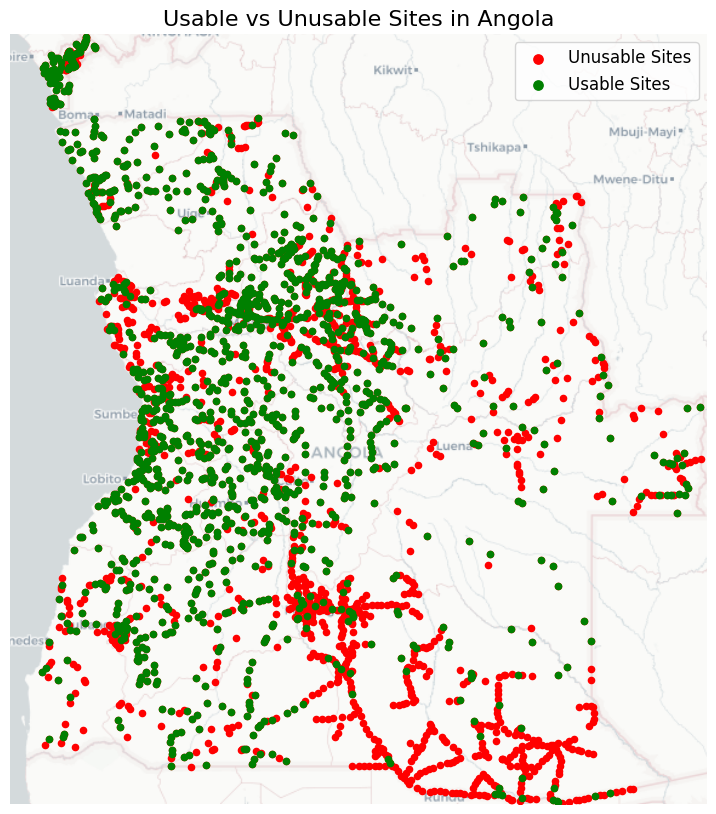

Number of usable sites: 1474
Number of unusable sites: 2771
Total sites: 4186


In [30]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# -------------------------------
# 1. Construct GeoDataFrames
# -------------------------------
gdf_all = gpd.GeoDataFrame(
    site_info,
    geometry=gpd.points_from_xy(site_info["X_coord"], site_info["Y_coord"]),
    crs="EPSG:4326"
)

gdf_usable = gpd.GeoDataFrame(
    usable_sites,
    geometry=gpd.points_from_xy(usable_sites["X_coord"], usable_sites["Y_coord"]),
    crs="EPSG:4326"
)

# Unusable = points in gdf_all but not in gdf_usable
gdf_unusable = gdf_all[~gdf_all.index.isin(gdf_usable.index)]

# -------------------------------
# 2. Clip points to Angola bounding box
# -------------------------------
# Angola bounding box in WGS84
min_lon, max_lon = 11.4609793, 24.0878856
min_lat, max_lat = -18.038945, -4.3880634

# Keep points inside Angola
gdf_all = gdf_all.cx[min_lon:max_lon, min_lat:max_lat]
gdf_usable = gdf_usable.cx[min_lon:max_lon, min_lat:max_lat]
gdf_unusable = gdf_unusable.cx[min_lon:max_lon, min_lat:max_lat]

# -------------------------------
# 3. Reproject to Web Mercator
# -------------------------------
gdf_all = gdf_all.to_crs(epsg=3857)
gdf_usable = gdf_usable.to_crs(epsg=3857)
gdf_unusable = gdf_unusable.to_crs(epsg=3857)

# Convert bounding box to Web Mercator for map limits
import pyproj
from shapely.geometry import box
from shapely.ops import transform

wgs84 = pyproj.CRS('EPSG:4326')
webmerc = pyproj.CRS('EPSG:3857')
project = pyproj.Transformer.from_crs(wgs84, webmerc, always_xy=True).transform
bbox_wgs = box(min_lon, min_lat, max_lon, max_lat)
bbox_3857 = transform(project, bbox_wgs)
minx, miny, maxx, maxy = bbox_3857.bounds

# -------------------------------
# 4. Plot
# -------------------------------
fig, ax = plt.subplots(figsize=(10, 10))

gdf_unusable.plot(ax=ax, color='red', markersize=20, label="Unusable Sites")
gdf_usable.plot(ax=ax, color='green', markersize=20, label="Usable Sites")

# Limit map to Angola bounding box
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Add basemap
ctx.add_basemap(ax, source="https://cartodb-basemaps-a.global.ssl.fastly.net/light_all/{z}/{x}/{y}.png")

plt.title("Usable vs Unusable Sites in Angola", fontsize=16)
plt.legend(markerscale=1.5, fontsize=12)
plt.axis("off")
plt.show()

# -------------------------------
# 5. Print counts
# -------------------------------
print("Number of usable sites:", len(gdf_usable))
print("Number of unusable sites:", len(gdf_unusable))
print("Total sites:", len(gdf_all))



🌍 GEOGRAPHIC DISTRIBUTION
------------------------------

🏘️ Sites per District:
Total districts: 18
district
Malanje            313
Cuanza Sul         179
Uige e Zaire       160
Huila              156
Benguela           146
Lundas e Moxico     94
Cabinda             94
Huambo              87
Bie                 79
Cuando-Cubango      65
Name: count, dtype: int64


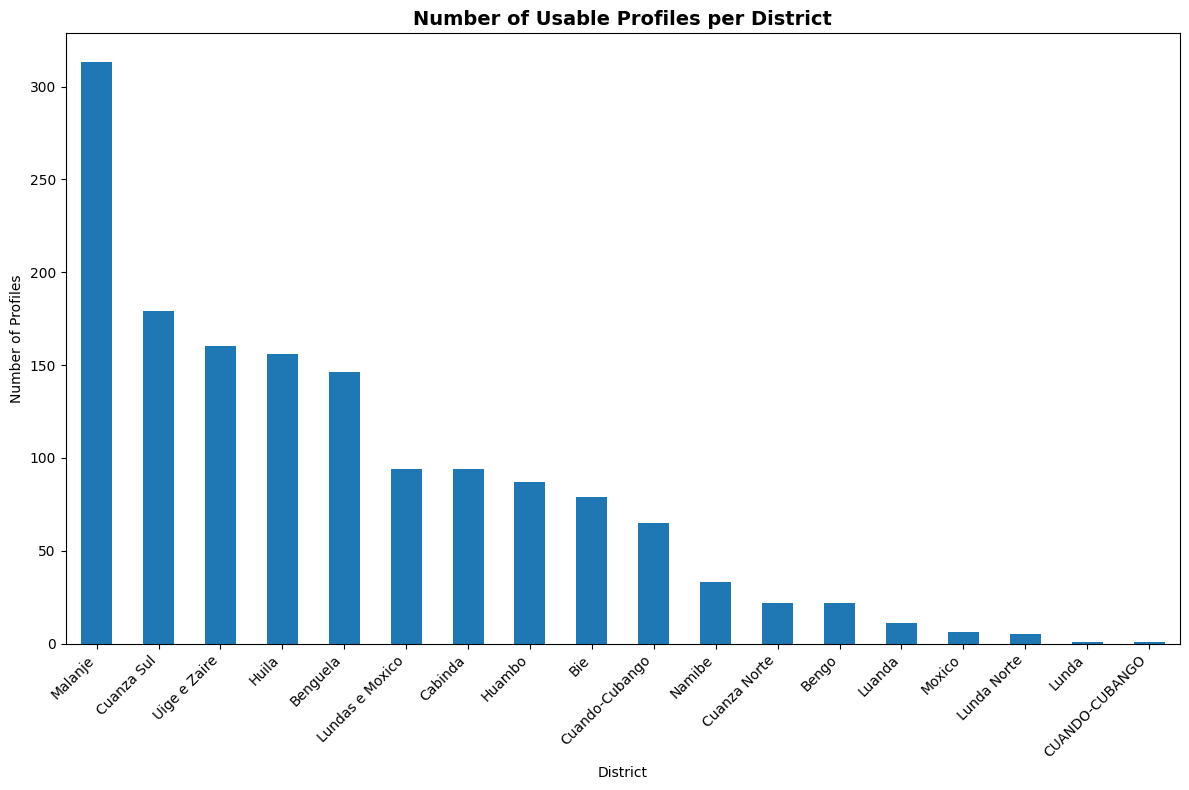

In [31]:
# === 2. GEOGRAPHIC DISTRIBUTION ANALYSIS ===
print(f"\n🌍 GEOGRAPHIC DISTRIBUTION")
print("-" * 30)
#print total usable sites 

# Sites per district/region
region_cols = ['district']  # Check which column exists
region_col = None
for col in region_cols:
    if col in usable_sites.columns:
        region_col = col
        break

if region_col:
    print(f"\n🏘️ Sites per {region_col.title()}:")
    region_counts = usable_sites[region_col].value_counts()
    print(f"Total {region_col}s: {len(region_counts)}")
    print(region_counts.head(10))
    
    # Plot top regions
    plt.figure(figsize=(12, 8))
    top_regions = region_counts.head(21)
    top_regions.plot(kind='bar')
    plt.title(f'Number of Usable Profiles per {region_col.title()}', fontsize=14, fontweight='bold')
    plt.xlabel(region_col.title())
    plt.ylabel('Number of Profiles')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [32]:
# === 3. CREATE MERGED DATASET ===

# Columns to select from analyses
analyses_cols = [
    'analysis_id', 'morpho_id', 'sample_id', 'profile', 'depth', 
    'thick_sand', 'fine_sand', 'silt', 'clay', 'atm_15', 'free_iron', 
    'organic_carbon', 'p205', 'organic_material', 'ph_h2o', 'ph_kcl', 
    'exchangable_bases_sum', 'cec', 'sample_depth', 'bulk_density', 'porosity'
]

# Subset analyses to relevant columns, ignoring missing cols gracefully
analyses_subset = analyses[[col for col in analyses_cols if col in analyses.columns]].copy()

# Filter analyses and morpho to only profiles present in site_info
valid_profiles = site_info['profile'].dropna().unique()

analyses_filtered = analyses_subset[analyses_subset['profile'].isin(valid_profiles)]
morpho_filtered = morpho[morpho['profile'].isin(valid_profiles)]

# Ensure matching dtypes for merge keys
analyses_filtered['sample_id'] = analyses_filtered['sample_id'].astype(str)
morpho_filtered['sample_id'] = morpho_filtered['sample_id'].astype(str)  # optional, since already object

# Now merge
combined_data = pd.merge(
    analyses_filtered,
    morpho_filtered,
    on=['profile', 'sample_id'],
    how='outer',
    suffixes=('', '_morpho')
)


# Inner join with site_info to keep only profiles with site info
merged_final = pd.merge(
    combined_data,
    site_info,
    on='profile',
    how='inner'
)

# Now merge with samples to add 'year' by sample_id
# Assuming 'samples' DataFrame is loaded and has 'sample_id' and 'year' columns
merged_final = pd.merge(
    merged_final,
    samples[['sample_id', 'year']],
    on='sample_id',
    how='inner'
)


/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_1641/265784574.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analyses_filtered['sample_id'] = analyses_filtered['sample_id'].astype(str)
/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_1641/265784574.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_filtered['sample_id'] = morpho_filtered['sample_id'].astype(str)  # optional, since already object



🧪 WORKING SAMPLES ANALYSIS (UNIQUE PROFILES)
----------------------------------------
Unique working profiles per district:
Total regions with samples: 17
Total unique working profiles: 1,315

Top 10 regions by unique profile count:
district
Malanje            309
Uige e Zaire       160
Cuanza Sul         155
Benguela           127
Huila              104
Lundas e Moxico     95
Cabinda             94
Huambo              85
Bie                 71
Cuando-Cubango      65
Name: count, dtype: int64


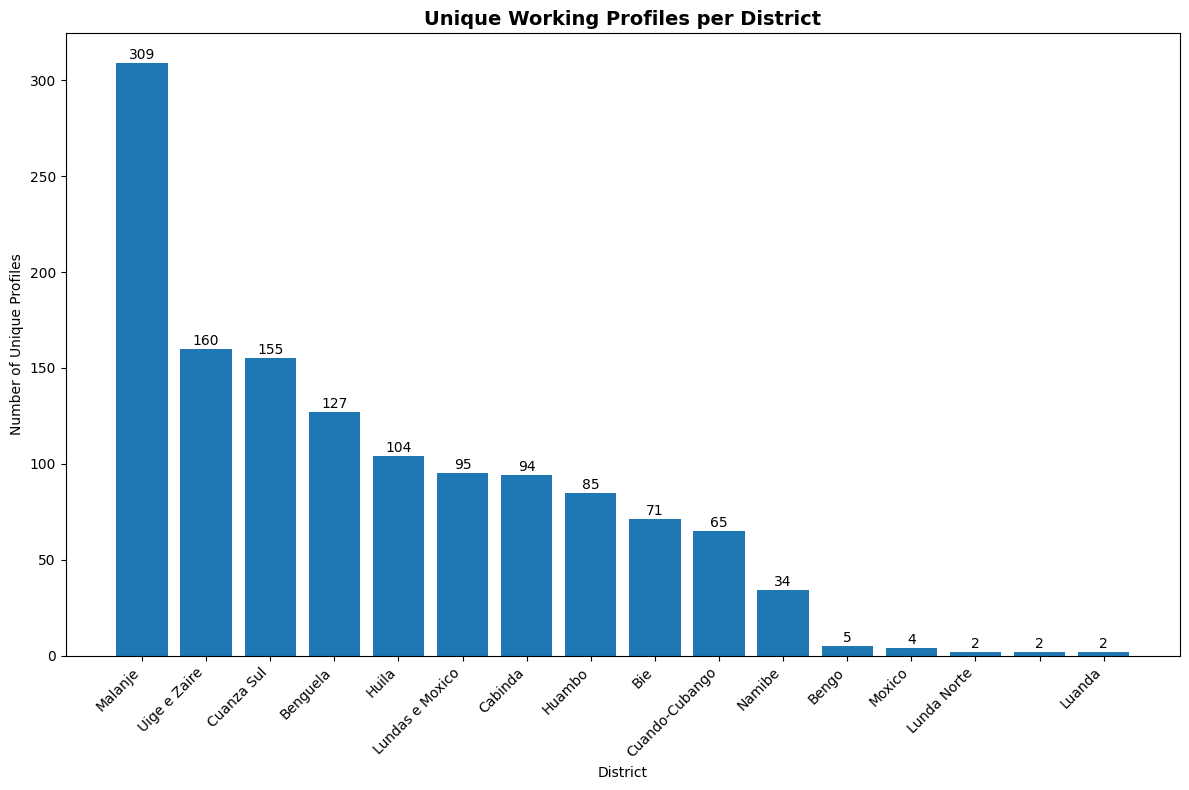

In [36]:
# === 4. WORKING SAMPLES ANALYSIS (UNIQUE PROFILES) ===
print(f"\n🧪 WORKING SAMPLES ANALYSIS (UNIQUE PROFILES)")
print("-" * 40)

# Samples with analysis data per region
if region_col and region_col in merged_final.columns:
    # Keep only unique profiles
    working_profiles = merged_final[merged_final['profile'].notna()].drop_duplicates(subset=['profile'])
    
    if len(working_profiles) > 0:
        # Count unique profiles per region
        profile_per_region = working_profiles[region_col].value_counts()
        print(f"Unique working profiles per {region_col}:")
        print(f"Total regions with samples: {len(profile_per_region)}")
        print(f"Total unique working profiles: {len(working_profiles):,}")
        print("\nTop 10 regions by unique profile count:")
        print(profile_per_region.head(10))
        
        # Plot unique profiles per region
        plt.figure(figsize=(12, 8))
        top_sample_regions = profile_per_region.head(16)
        bars = plt.bar(range(len(top_sample_regions)), top_sample_regions.values)
        plt.title(f'Unique Working Profiles per {region_col.title()}', fontsize=14, fontweight='bold')
        plt.xlabel(region_col.title())
        plt.ylabel('Number of Unique Profiles')
        plt.xticks(range(len(top_sample_regions)), top_sample_regions.index, rotation=45, ha='right')
        
        # Add value labels on bars
        for i, bar in enumerate(bars):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                     str(top_sample_regions.values[i]), ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()


In [15]:
merged_final.columns

Index(['analysis_id', 'morpho_id', 'sample_id', 'profile', 'depth',
       'thick_sand', 'fine_sand', 'silt', 'clay', 'atm_15', 'free_iron',
       'organic_carbon', 'p205', 'organic_material', 'ph_h2o', 'ph_kcl',
       'exchangable_bases_sum', 'cec', 'sample_depth', 'bulk_density',
       'porosity', 'morpho_id_morpho', 'horizon_layer', 'upper_depth',
       'lower_depth', 'moisture_degree', 'root_quantity', 'root_diameter',
       'texture', 'structure_type', 'structure_class', 'structure_degree',
       'pore_diameter', 'pore_quantity', 'pore_shape', 'dry_color_name',
       'dry_hue', 'dry_value', 'dry_chroma', 'moist_color_name', 'moist_hue',
       'moist_value', 'moist_chroma', 'compaction', 'durability', 'friability',
       'thick_contents_count', 'thick_contents_nature', 'site_info_id',
       'X_coord', 'Y_coord', 'district', 'geo_features_id', 'climate_id',
       'topo_id', 'soil_type_id', 'geom', 'year'],
      dtype='object')

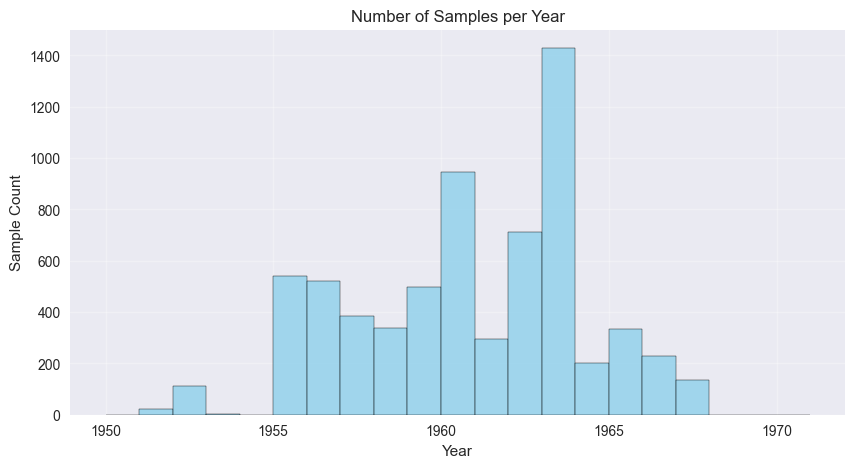

In [18]:
#Number of Samples per Year

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(merged_final['year'], bins=range(1950, 1972), kde=False, color='skyblue')

plt.title('Number of Samples per Year')
plt.xlabel('Year')
plt.ylabel('Sample Count')
plt.grid(True, alpha=0.3)
plt.show()


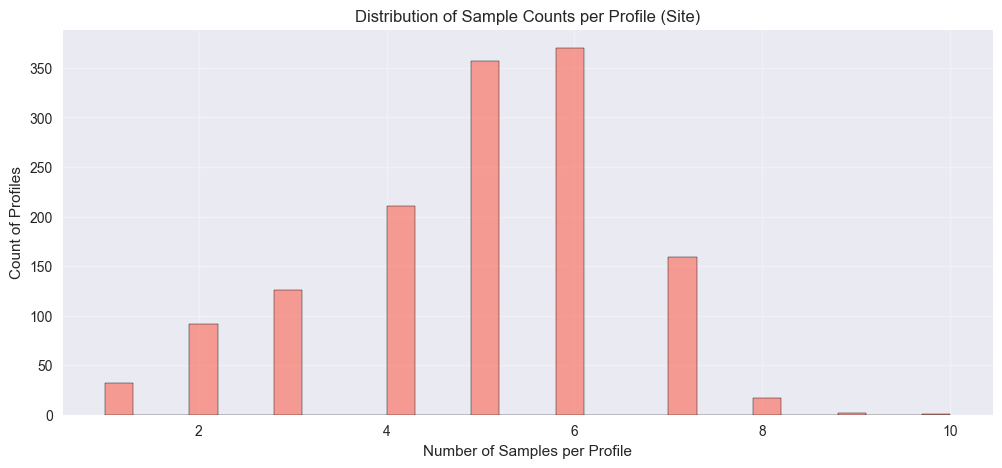

In [19]:
#Number of Samples per Profile

plt.figure(figsize=(12, 5))

# Count samples per profile
profile_counts = merged_final['profile'].value_counts()

sns.histplot(profile_counts, bins=30, color='salmon')

plt.title('Distribution of Sample Counts per Profile (Site)')
plt.xlabel('Number of Samples per Profile')
plt.ylabel('Count of Profiles')
plt.grid(True, alpha=0.3)
plt.show()



🧪 WORKING SAMPLES ANALYSIS
------------------------------
Working samples per district:
Total districts with samples: 16
Total working samples: 6,667

Top 10 districts by sample count:
district
Malanje            1421
Uige e Zaire        870
Cuanza Sul          723
Huila               699
Benguela            631
Lundas e Moxico     523
Cabinda             468
Huambo              450
Bie                 365
Cuando-Cubango      319
Name: count, dtype: int64


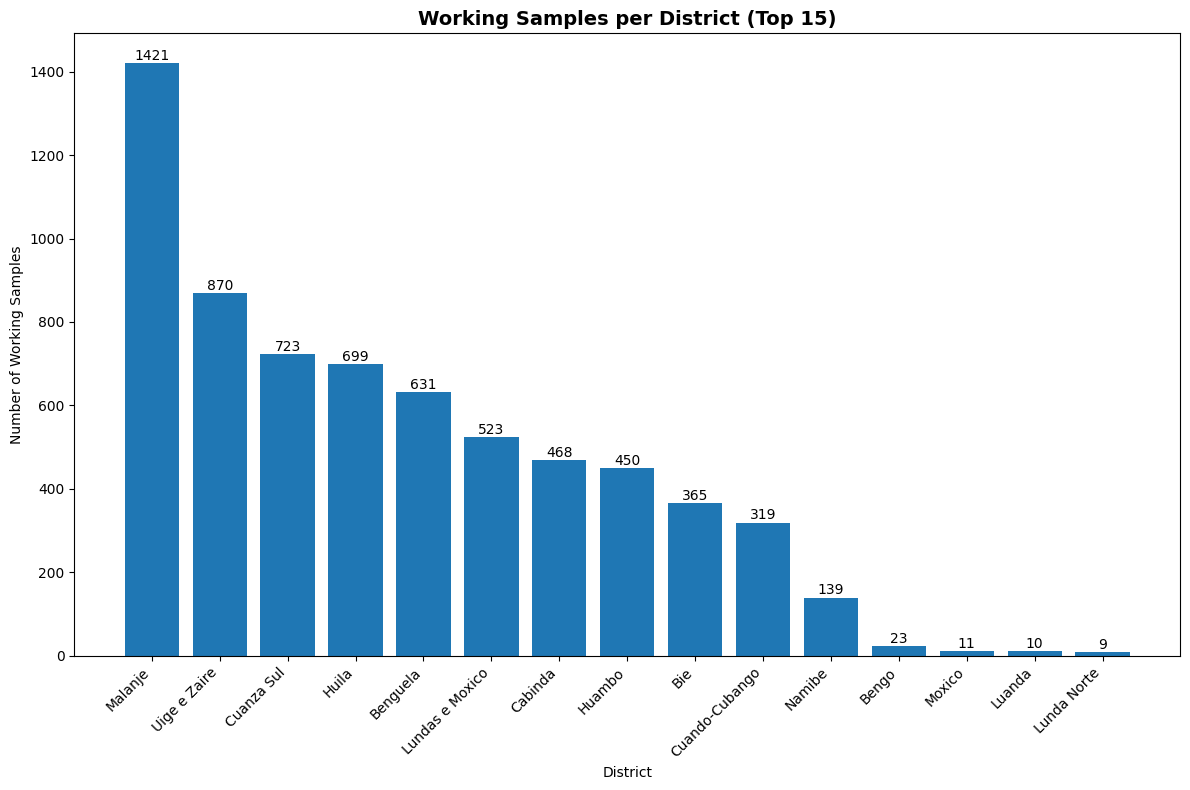

In [20]:
#  WORKING SAMPLES ANALYSIS 
print(f"\n🧪 WORKING SAMPLES ANALYSIS")
print("-" * 30)

# Samples with analysis data per district
if 'district' in merged_final.columns:
    working_samples = merged_final[merged_final['analysis_id'].notna()]
    
    if len(working_samples) > 0:
        samples_per_district = working_samples['district'].value_counts()
        
        print(f"Working samples per district:")
        print(f"Total districts with samples: {len(samples_per_district)}")
        print(f"Total working samples: {len(working_samples):,}")
        print("\nTop 10 districts by sample count:")
        print(samples_per_district.head(10))
        
        # Plot working samples per district
        plt.figure(figsize=(12, 8))
        top_sample_districts = samples_per_district.head(15)
        bars = plt.bar(range(len(top_sample_districts)), top_sample_districts.values)
        plt.title('Working Samples per District (Top 15)', fontsize=14, fontweight='bold')
        plt.xlabel('District')
        plt.ylabel('Number of Working Samples')
        plt.xticks(range(len(top_sample_districts)), top_sample_districts.index, rotation=45, ha='right')
        
        # Add value labels on bars
        for i, bar in enumerate(bars):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    str(top_sample_districts.values[i]), ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()


🏔️ SOIL HORIZON ANALYSIS
------------------------------
Horizon Depth analysis:
  Total profiles: 1,315
  Average horizons depths per site: 4.97
  Median horizon depths per site: 5
  Min horizon depths: 1
  Max horizon depths: 10

Distribution of horizon depths per site:
1      30
2      80
3     117
4     195
5     349
6     366
7     159
8      16
9       2
10      1
Name: count, dtype: int64


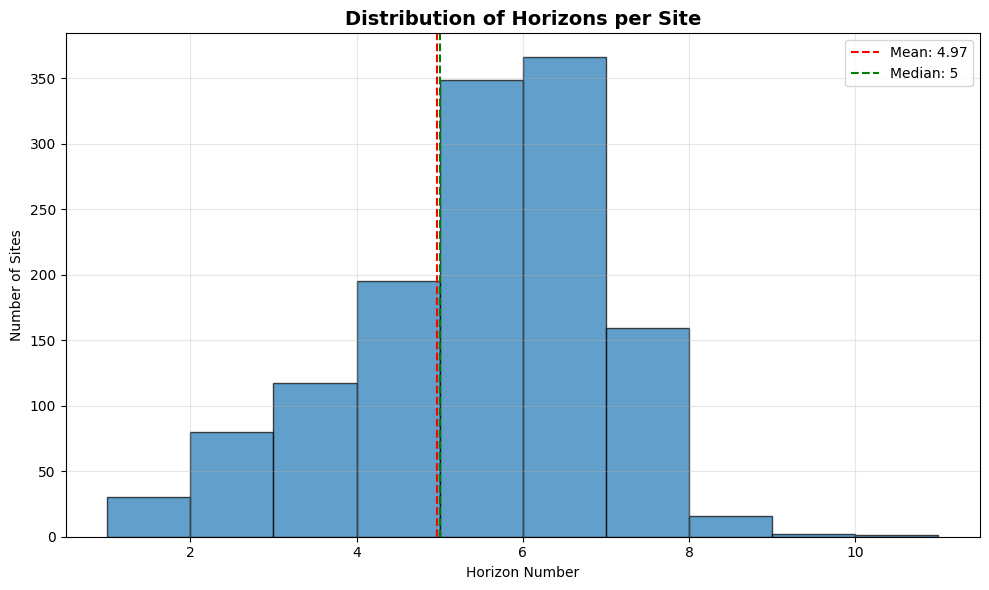

In [38]:
# === 5. HORIZON ANALYSIS ===
print(f"\n🏔️ SOIL HORIZON ANALYSIS")
print("-" * 30)

# Group by profile to analyze horizons per site
profile_col = 'profile'
if profile_col in merged_final.columns:
    # Count horizons per profile/site
    horizons_per_site = merged_final.groupby(profile_col).size()
    
    print(f"Horizon Depth analysis:")
    print(f"  Total profiles: {len(horizons_per_site):,}")
    print(f"  Average horizons depths per site: {horizons_per_site.mean():.2f}")
    print(f"  Median horizon depths per site: {horizons_per_site.median():.0f}")
    print(f"  Min horizon depths: {horizons_per_site.min()}")
    print(f"  Max horizon depths: {horizons_per_site.max()}")
    
    print(f"\nDistribution of horizon depths per site:")
    horizon_distribution = horizons_per_site.value_counts().sort_index()
    print(horizon_distribution.head(10))
    
    # Plot histogram of horizons per site
    plt.figure(figsize=(10, 6))
    plt.hist(horizons_per_site, bins=range(1, horizons_per_site.max() + 2), 
             edgecolor='black', alpha=0.7)
    plt.title('Distribution of Horizons per Site', fontsize=14, fontweight='bold')
    plt.xlabel('Horizon Number')
    plt.ylabel('Number of Sites')
    plt.grid(True, alpha=0.3)
    
    # Add statistics text
    plt.axvline(horizons_per_site.mean(), color='red', linestyle='--', 
                label=f'Mean: {horizons_per_site.mean():.2f}')
    plt.axvline(horizons_per_site.median(), color='green', linestyle='--', 
                label=f'Median: {horizons_per_site.median():.0f}')
    plt.legend()
    plt.tight_layout()
    plt.show()


📏 DEPTH ANALYSIS
------------------------------
Depth analysis (using 'sample_depth'):
  Total depth measurements: 6,667
  Depth range: -70.0 to 131.0
  Mean depth: 25.6
  Median depth: 26.0


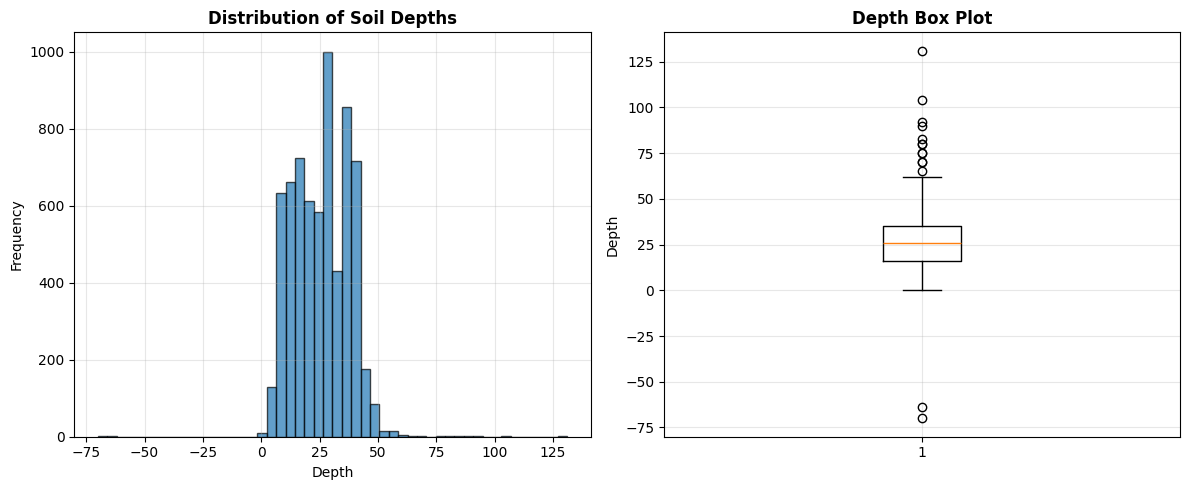

In [21]:
# DEPTH ANALYSIS 
print(f"\n📏 DEPTH ANALYSIS")
print("-" * 30)

# Define the depth column you want to use
depth_col = 'sample_depth'

if depth_col in merged_final.columns:
    depths = merged_final[depth_col].dropna()

    if len(depths) > 0:
        print(f"Depth analysis (using '{depth_col}'):")
        print(f"  Total depth measurements: {len(depths):,}")
        print(f"  Depth range: {depths.min():.1f} to {depths.max():.1f}")
        print(f"  Mean depth: {depths.mean():.1f}")
        print(f"  Median depth: {depths.median():.1f}")
        
        # Plot depth distribution
        plt.figure(figsize=(12, 5))
        
        # Histogram
        plt.subplot(1, 2, 1)
        plt.hist(depths, bins=50, edgecolor='black', alpha=0.7)
        plt.title('Distribution of Soil Depths', fontsize=12, fontweight='bold')
        plt.xlabel('Depth')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        
        # Boxplot
        plt.subplot(1, 2, 2)
        plt.boxplot(depths)
        plt.title('Depth Box Plot', fontsize=12, fontweight='bold')
        plt.ylabel('Depth')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"No valid values found in '{depth_col}'.")
else:
    print(f"Column '{depth_col}' not found in DataFrame.")


In [ ]:
## find out where thata -75 depth is and take it out

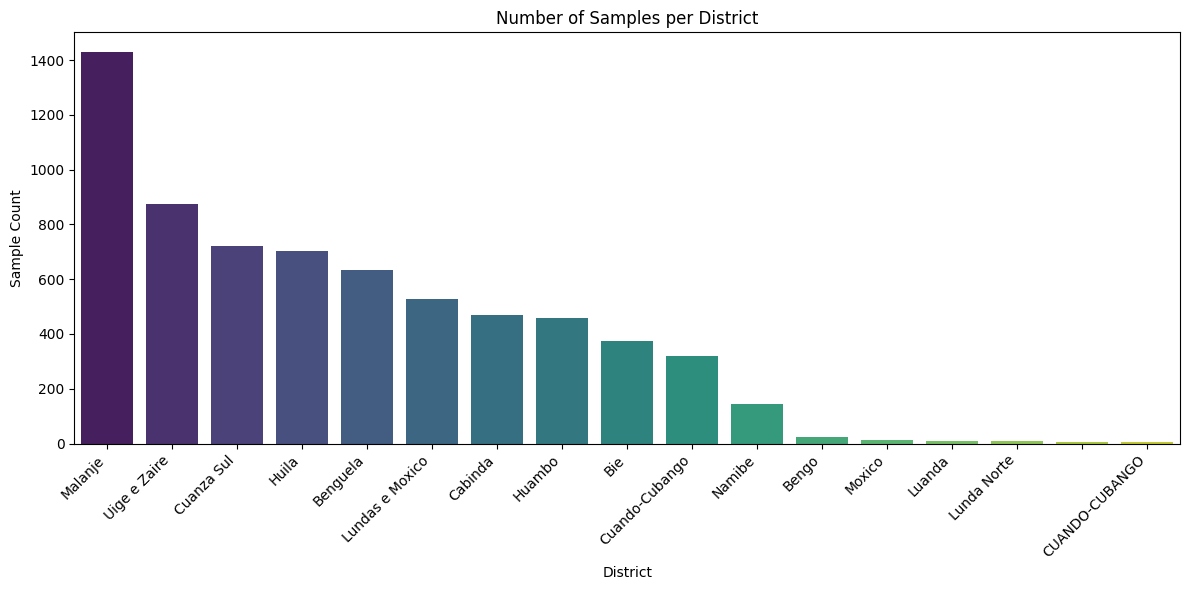

In [19]:
#Number of Samples per District (not representative of working dataset)

plt.figure(figsize=(12, 6))

district_counts = merged_final['district'].value_counts().reset_index()
district_counts.columns = ['district', 'sample_count']

sns.barplot(data=district_counts, x='district', y='sample_count', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Number of Samples per District')
plt.xlabel('District')
plt.ylabel('Sample Count')
plt.tight_layout()
plt.show()



In [22]:
# === 7. HORIZON DESIGNATION ANALYSIS ===
# Check columns exist
required_cols = ['profile', 'horizon_layer', 'sample_depth', 'upper_depth', 'lower_depth']
missing_cols = [col for col in required_cols if col not in merged_final.columns]

if missing_cols:
    print(f"Missing columns: {missing_cols}")
else:
    # Drop rows with missing depth info to avoid errors
    df = merged_final.dropna(subset=['profile', 'horizon_layer', 'upper_depth', 'lower_depth'])

    # Group by profile
    horizon_summary = df.groupby('profile').agg(
        num_horizons = ('horizon_layer', 'nunique'),             # count unique horizons
        min_depth = ('upper_depth', 'min'),                      # shallowest start
        max_depth = ('lower_depth', 'max'),                      # deepest end
        total_thickness = ('sample_depth', 'sum')                # sum thickness of horizons
    ).reset_index()

    print(horizon_summary)

    # # Optional: Show profiles with their number of horizons and depth range nicely
    # for _, row in horizon_summary.iterrows():
    #     print(f"Profile {row['profile']}: {row['num_horizons']} horizons, depth range {row['min_depth']} - {row['max_depth']} cm, total thickness {row['total_thickness']:.1f} cm")


      profile  num_horizons  min_depth  max_depth  total_thickness
0      100_56             4        0.0      190.0             90.0
1      100_58             4        0.0      110.0             87.0
2      100_59             2       17.0       67.0             50.0
3      100_63             7        0.0      142.0            142.0
4     101A_58             5        0.0      113.0            108.0
...       ...           ...        ...        ...              ...
1141    99_63             6        0.0      170.0            130.0
1142    9C_60             6        0.0      170.0            148.0
1143    9C_63             5        0.0      170.0            125.0
1144     9_62             5        0.0      175.0            109.0
1145     9_63             5        0.0       90.0             90.0

[1146 rows x 5 columns]



Summary Statistics:
       num_horizons    min_depth    max_depth  total_thickness
count   2218.000000  2218.000000  2218.000000      2218.000000
mean       4.698377     0.120153   145.093327       413.403517
std        1.283674     2.966375    43.466149       378.331108
min        1.000000     0.000000     8.000000         0.000000
25%        4.000000     0.000000   115.000000         0.000000
50%        5.000000     0.000000   165.000000       368.000000
75%        6.000000     0.000000   175.000000       715.000000
max        9.000000   116.000000   280.000000      1722.000000


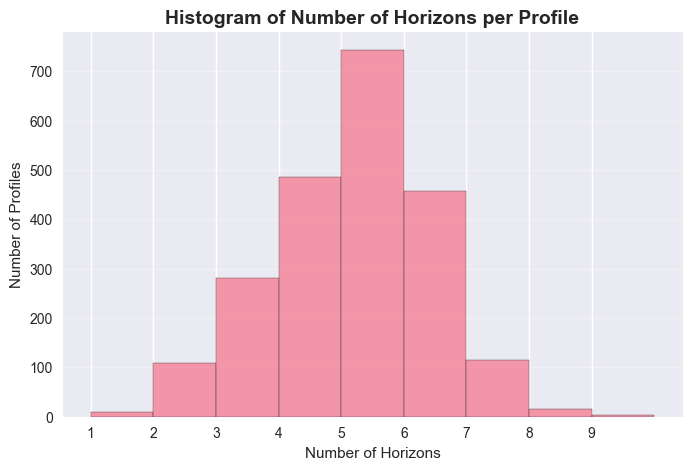

In [29]:
import matplotlib.pyplot as plt

# Assuming `horizon_summary` is the DataFrame from before

# Summary statistics for numeric columns
summary_stats = horizon_summary.describe()
print("\nSummary Statistics:")
print(summary_stats[['num_horizons', 'min_depth', 'max_depth', 'total_thickness']])

# Histogram for number of horizons per profile
plt.figure(figsize=(8,5))
plt.hist(horizon_summary['num_horizons'], bins=range(1, horizon_summary['num_horizons'].max() + 2), 
         edgecolor='black', alpha=0.7)
plt.title('Histogram of Number of Horizons per Profile', fontsize=14, fontweight='bold')
plt.xlabel('Number of Horizons')
plt.ylabel('Number of Profiles')
plt.grid(axis='y', alpha=0.3)
plt.xticks(range(1, horizon_summary['num_horizons'].max() + 1))
plt.show()

In [ ]:
#General EDA questions
# what is it? graphical output and descriptive statistics for our data

#ABOUT THE DATA
# How many sites per country
# how many sites per district
# do I need to break into even more specific site groupings

# histogram of sites per region
# histogram of working samples per region

# How many horizon layers per site
# depth range of horizon layers
# classify depth by its soil horizon designation

# generalize horizon labels --find out if any python package/function can set horizon label basd

#crosstabulate
## soil designation (taxonomic group and particle size)

#Pattern matching
## variation of particle size classes are within a specific subgroup (like a specific soil horizon)
## pattern match on taxonomic group, geomorphology or parent material

# filtering

# common landforms in area, commanalities in climate, 
    ## parent material, taxonomic history, geomorphic data, ecological site history (?) useful


## Descriptive statistics
# mean, medium, and mode clay, sand, silt content
# number of observations for each horizon, for each site


## EDA is interesting but carbon stock not updated to FAO standards \\ Need to replace with actual SOC stock values

In [16]:
## carbon stock calculation test
# Ensure no missing values in required columns for calculation
cols_needed = ['organic_carbon', 'bulk_density', 'sample_depth']
df_soc = merged_final.dropna(subset=cols_needed).copy()

# Calculate SOC stock (mg C/cm²)
df_soc['SOC_stock_mg_per_cm2'] = (
    df_soc['bulk_density'] *
    df_soc['organic_carbon'] *
    df_soc['sample_depth']
)

# Optional: display summary statistics
print(df_soc['SOC_stock_mg_per_cm2'].describe())

# If you want to add this back to your main dataframe (aligned by index)
merged_final = merged_final.merge(
    df_soc[['SOC_stock_mg_per_cm2']],
    left_index=True,
    right_index=True,
    how='left'
)


count    4510.000000
mean       17.100433
std        16.884321
min       -28.421250
25%         7.821887
50%        13.209234
75%        21.249074
max       352.531441
Name: SOC_stock_mg_per_cm2, dtype: float64


In [11]:
# soc stock summary by profile and district

import pandas as pd
from scipy import stats  # for mode calculation

# Make sure 'SOC_stock_mg_per_cm2' exists and drop NA to avoid errors
df = merged_final.dropna(subset=['SOC_stock_mg_per_cm2'])

# Helper function to calculate mode, returns first mode or NaN if no mode found
def calc_mode(series):
    modes = stats.mode(series, nan_policy='omit')
    if modes.count[0] > 0:
        return modes.mode[0]
    else:
        return pd.NA

# 1. Aggregate by profile
profile_stats = df.groupby('profile')['SOC_stock_mg_per_cm2'].agg(
    average='mean',
    median='median',
    sum='sum',
).reset_index()

# Calculate mode separately because pandas doesn't support mode in agg well
profile_modes = df.groupby('profile')['SOC_stock_mg_per_cm2'].apply(calc_mode).reset_index(name='mode')

# Merge mode into profile_stats
profile_stats = profile_stats.merge(profile_modes, on='profile')

# 2. Aggregate by district (replace 'district' with actual column name)
district_stats = df.groupby('district')['SOC_stock_mg_per_cm2'].agg(
    average='mean',
    median='median',
    sum='sum',
).reset_index()

district_modes = df.groupby('district')['SOC_stock_mg_per_cm2'].apply(calc_mode).reset_index(name='mode')

district_stats = district_stats.merge(district_modes, on='district')

# 3. Total SOC stock for Angola (sum over all)
total_soc_stock = df['SOC_stock_mg_per_cm2'].sum()

print("SOC Stock Summary by Profile:")
print(profile_stats.head())

print("\nSOC Stock Summary by District:")
print(district_stats.head())

print(f"\nTotal SOC Stock for Angola (mg C/cm²): {total_soc_stock:,.2f}")


SOC Stock Summary by Profile:
  profile    average     median         sum       mode
0  100_56  13.161807  14.110696   65.809035   5.011545
1  100_58  22.098545  22.648197   66.295634  19.096803
2  100_59  22.342839  23.770139   67.028517  18.161480
3  100_61  27.623042  26.612822  110.492169  17.749443
4  100_63   6.764940   7.024606   33.824698   3.598951

SOC Stock Summary by District:
         district    average     median          sum       mode
0           Bengo  11.550878   6.616137   265.670190   1.883289
1        Benguela  17.319886  12.939734  7811.268727  10.919386
2             Bie  13.310534  10.135932  3607.154612   1.494137
3  CUANDO-CUBANGO   3.752881   2.835345    18.764406   1.925097
4         Cabinda  20.020194  17.424739  4724.765812   4.982655

Total SOC Stock for Angola (mg C/cm²): 77,122.95


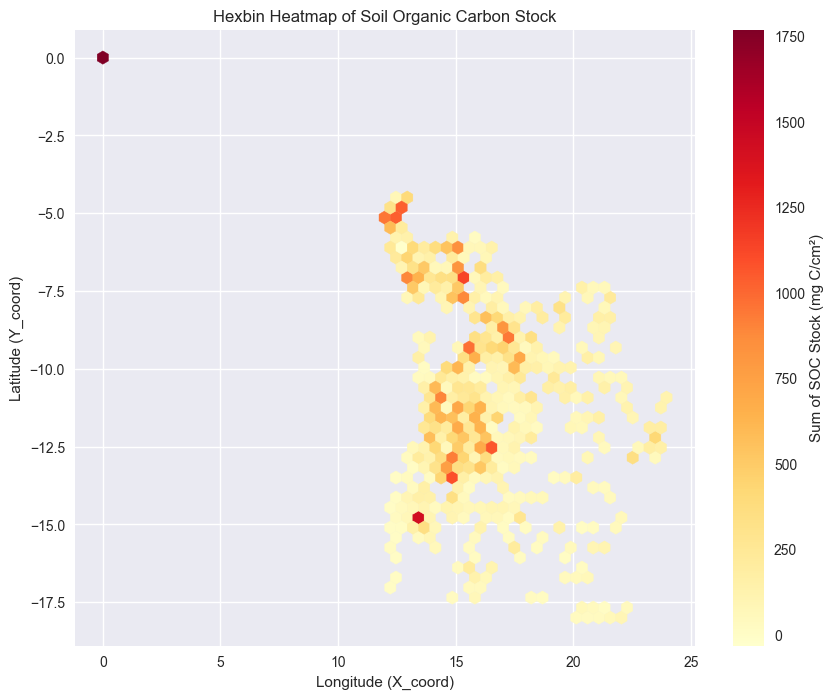

In [12]:
#heat map

import numpy as np
import matplotlib.pyplot as plt

df_plot = merged_final.dropna(subset=['X_coord', 'Y_coord', 'SOC_stock_mg_per_cm2'])

plt.figure(figsize=(10, 8))

hb = plt.hexbin(
    df_plot['X_coord'], 
    df_plot['Y_coord'], 
    C=df_plot['SOC_stock_mg_per_cm2'], 
    gridsize=50, 
    cmap='YlOrRd', 
    reduce_C_function=np.sum
)

plt.colorbar(hb, label='Sum of SOC Stock (mg C/cm²)')
plt.title("Hexbin Heatmap of Soil Organic Carbon Stock")
plt.xlabel("Longitude (X_coord)")
plt.ylabel("Latitude (Y_coord)")
plt.show()


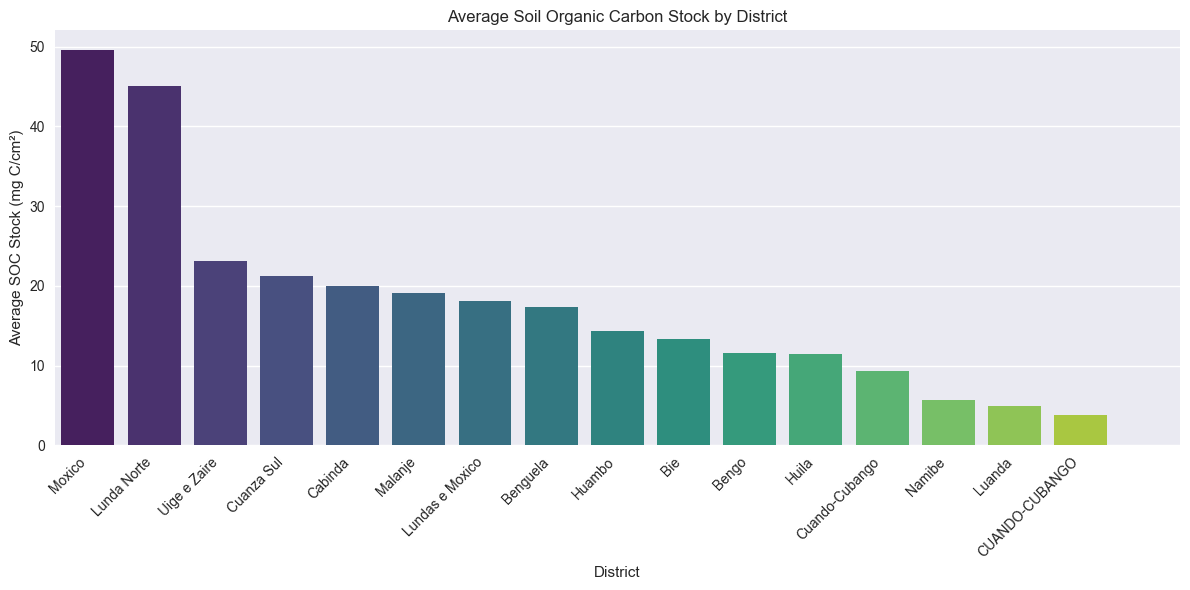

In [13]:
# Average Soil Organic Carbon Stock by District'

import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate average SOC stock per district
district_summary = merged_final.groupby('district')['SOC_stock_mg_per_cm2'].mean().reset_index()

# Sort districts by average SOC for nicer plotting
district_summary = district_summary.sort_values(by='SOC_stock_mg_per_cm2', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=district_summary, x='district', y='SOC_stock_mg_per_cm2', palette='viridis')

plt.xticks(rotation=45, ha='right')
plt.title('Average Soil Organic Carbon Stock by District')
plt.ylabel('Average SOC Stock (mg C/cm²)')
plt.xlabel('District')
plt.tight_layout()
plt.show()


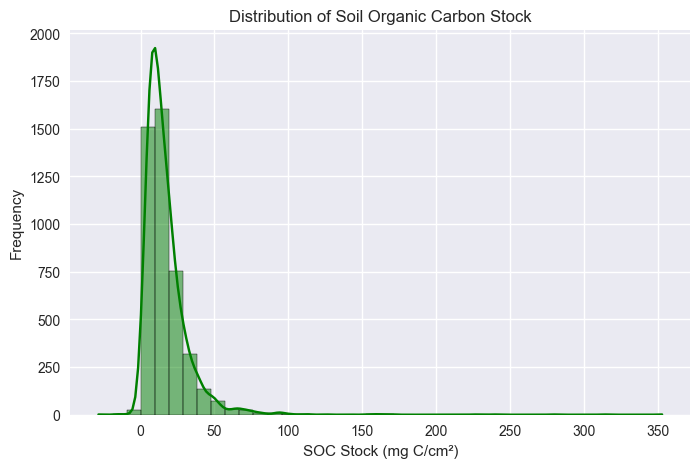

In [14]:
#histogram of dist of SOC stock

plt.figure(figsize=(8, 5))

sns.histplot(merged_final['SOC_stock_mg_per_cm2'].dropna(), bins=40, kde=True, color='green')

plt.title('Distribution of Soil Organic Carbon Stock')
plt.xlabel('SOC Stock (mg C/cm²)')
plt.ylabel('Frequency')
plt.show()


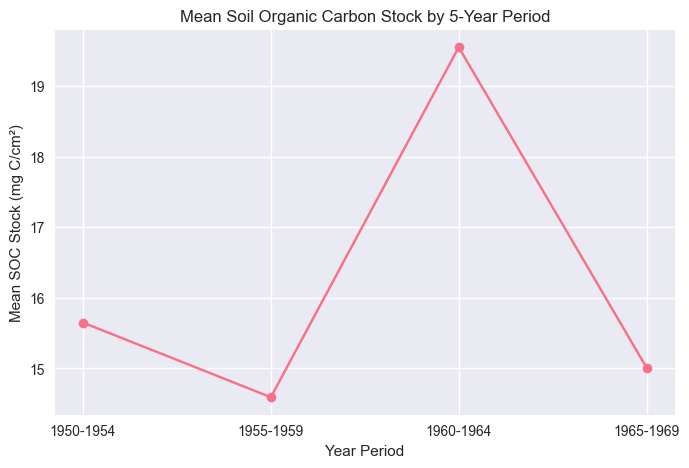

In [15]:
#Mean Soil Organic Carbon Stock by 5-Year Period'


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create 5-year bins
bins = list(range(1950, 1975, 5))
labels = [f"{b}-{b+4}" for b in bins[:-1]]
merged_final['year_bin'] = pd.cut(merged_final['year'], bins=bins, labels=labels, right=False)

# Aggregate mean SOC stock per bin
soc_by_bin = merged_final.groupby('year_bin')['SOC_stock_mg_per_cm2'].mean().reset_index()

plt.figure(figsize=(8,5))
plt.plot(soc_by_bin['year_bin'], soc_by_bin['SOC_stock_mg_per_cm2'], marker='o')
plt.title('Mean Soil Organic Carbon Stock by 5-Year Period')
plt.xlabel('Year Period')
plt.ylabel('Mean SOC Stock (mg C/cm²)')
plt.grid(True)
plt.show()


                             OLS Regression Results                             
Dep. Variable:     SOC_stock_mg_per_cm2   R-squared:                       0.065
Model:                              OLS   Adj. R-squared:                  0.003
Method:                   Least Squares   F-statistic:                     1.046
Date:                  Tue, 12 Aug 2025   Prob (F-statistic):              0.323
Time:                          15:34:23   Log-Likelihood:                -58.789
No. Observations:                    17   AIC:                             121.6
Df Residuals:                        15   BIC:                             123.2
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        700.5630    684.321

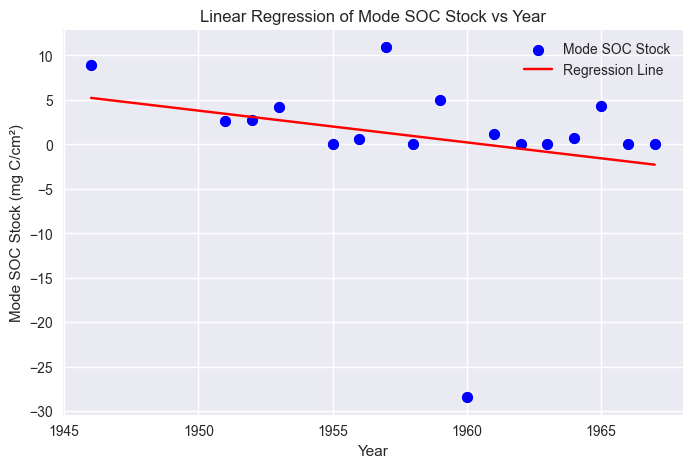

In [17]:
# OLS Regression and regression line (not suer why i ran this)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
import statsmodels.api as sm

# Compute mode SOC stock per year
# Since mode returns an array and count, we get the first mode value for each year
def get_mode(series):
    m = mode(series, nan_policy='omit')
    if len(m.mode) > 0:
        return m.mode[0]
    else:
        return np.nan

mode_per_year = merged_final.groupby('year')['SOC_stock_mg_per_cm2'].apply(get_mode).reset_index()

# Drop years with NaN mode
mode_per_year = mode_per_year.dropna()

# Prepare data for regression
X = mode_per_year['year']
y = mode_per_year['SOC_stock_mg_per_cm2']

# Add constant for intercept
X_const = sm.add_constant(X)

# Fit linear regression model
model = sm.OLS(y, X_const).fit()

print(model.summary())

# Plot the data and regression line
plt.figure(figsize=(8,5))
sns.scatterplot(x='year', y='SOC_stock_mg_per_cm2', data=mode_per_year, s=80, color='blue', label='Mode SOC Stock')
plt.plot(X, model.predict(X_const), color='red', label='Regression Line')
plt.title('Linear Regression of Mode SOC Stock vs Year')
plt.xlabel('Year')
plt.ylabel('Mode SOC Stock (mg C/cm²)')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
merged_final.columns

Index(['analysis_id', 'morpho_id', 'sample_id', 'profile', 'depth',
       'thick_sand', 'fine_sand', 'silt', 'clay', 'atm_15', 'free_iron',
       'organic_carbon', 'p205', 'organic_material', 'ph_h2o', 'ph_kcl',
       'exchangable_bases_sum', 'cec', 'sample_depth', 'bulk_density',
       'porosity', 'morpho_id_morpho', 'horizon_layer', 'upper_depth',
       'lower_depth', 'moisture_degree', 'root_quantity', 'root_diameter',
       'texture', 'structure_type', 'structure_class', 'structure_degree',
       'pore_diameter', 'pore_quantity', 'pore_shape', 'dry_color_name',
       'dry_hue', 'dry_value', 'dry_chroma', 'moist_color_name', 'moist_hue',
       'moist_value', 'moist_chroma', 'compaction', 'durability', 'friability',
       'thick_contents_count', 'thick_contents_nature', 'site_info_id',
       'X_coord', 'Y_coord', 'district', 'geo_features_id', 'climate_id',
       'topo_id', 'soil_type_id', 'geom', 'year', 'SOC_stock_mg_per_cm2',
       'year_bin'],
      dtype='object')